In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
import pandas as pd
import math
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def plot_projections(ts, points, method_name):
    fig, ax = plt.subplots(figsize=(40, 40))
    ax.set_xlim([ts.min(), ts.max()])
    ax.set_ylim([points.min(), points.max()])
    
    red_patch = mpatches.Patch(color='red', label='X trajectory')
    green_patch = mpatches.Patch(color='green', label='Y trajectory ')
    blue_patch = mpatches.Patch(color='blue', label='Z trajectory')
    
    plt.legend(handles=[red_patch, green_patch, blue_patch], prop={'size':30}, loc=2)
    plt.title(method_name, size=30)
    ax.scatter(ts, points[:, 0], color='red', marker=',')
    ax.scatter(ts, points[:, 1], color='green', marker=',')
    ax.scatter(ts, points[:, 2], color='blue', marker=',')
    
def plot3D(points, method_name):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(points[:,0],points[:,1],points[:,2])

In [3]:
sigma = 10
b = 8.0/3
#dx/dt=-sigma*x+sigma*y
#dy/dt=-x*z+r*x-y
#dz/dt=x*y-b*z
def lorenz_fun(r, vec): 
    x,y,z=vec
    return np.array([sigma*(y-x), x*(r-z)-y, x*y-b*z])

In [4]:
start_x=np.array([10.0, -7.0, 4.0])

In [5]:
def converge_to(method, start_x):
    ts, points = method(start_x)
    return points[-1]

In [9]:
def plot_graphs(method_name, method, start_x, r, t_a=0, t_b=100, dt=0.001):
    fun = lambda vec: lorenz_fun(r, vec)
    ts, points = method(start_x, r, fun, t_a, t_b, dt)
    print(points[-1])
    np.savetxt("Debug/Content/data.csv", points, delimiter=' ')
    plot_projections(ts, points, method_name)
    plot3D(points, method_name)

In [10]:
def euler_method(start_x, r, fun=None, t_a=0, t_b=100, dt=0.001):
    if fun is None:
        fun = lambda vec: lorenz_fun(r, vec)
    cur_t = t_a
    cur_x = np.copy(start_x)
    ts = [cur_t]
    way = [cur_x]
    while cur_t <= t_b:
        cur_x += fun(cur_x)*dt
        cur_t += dt
        way.append(np.copy(cur_x))
        ts.append(cur_t)
    return (np.array(ts), np.array(way))

[ 11.6784086    8.30075448  31.18549149]


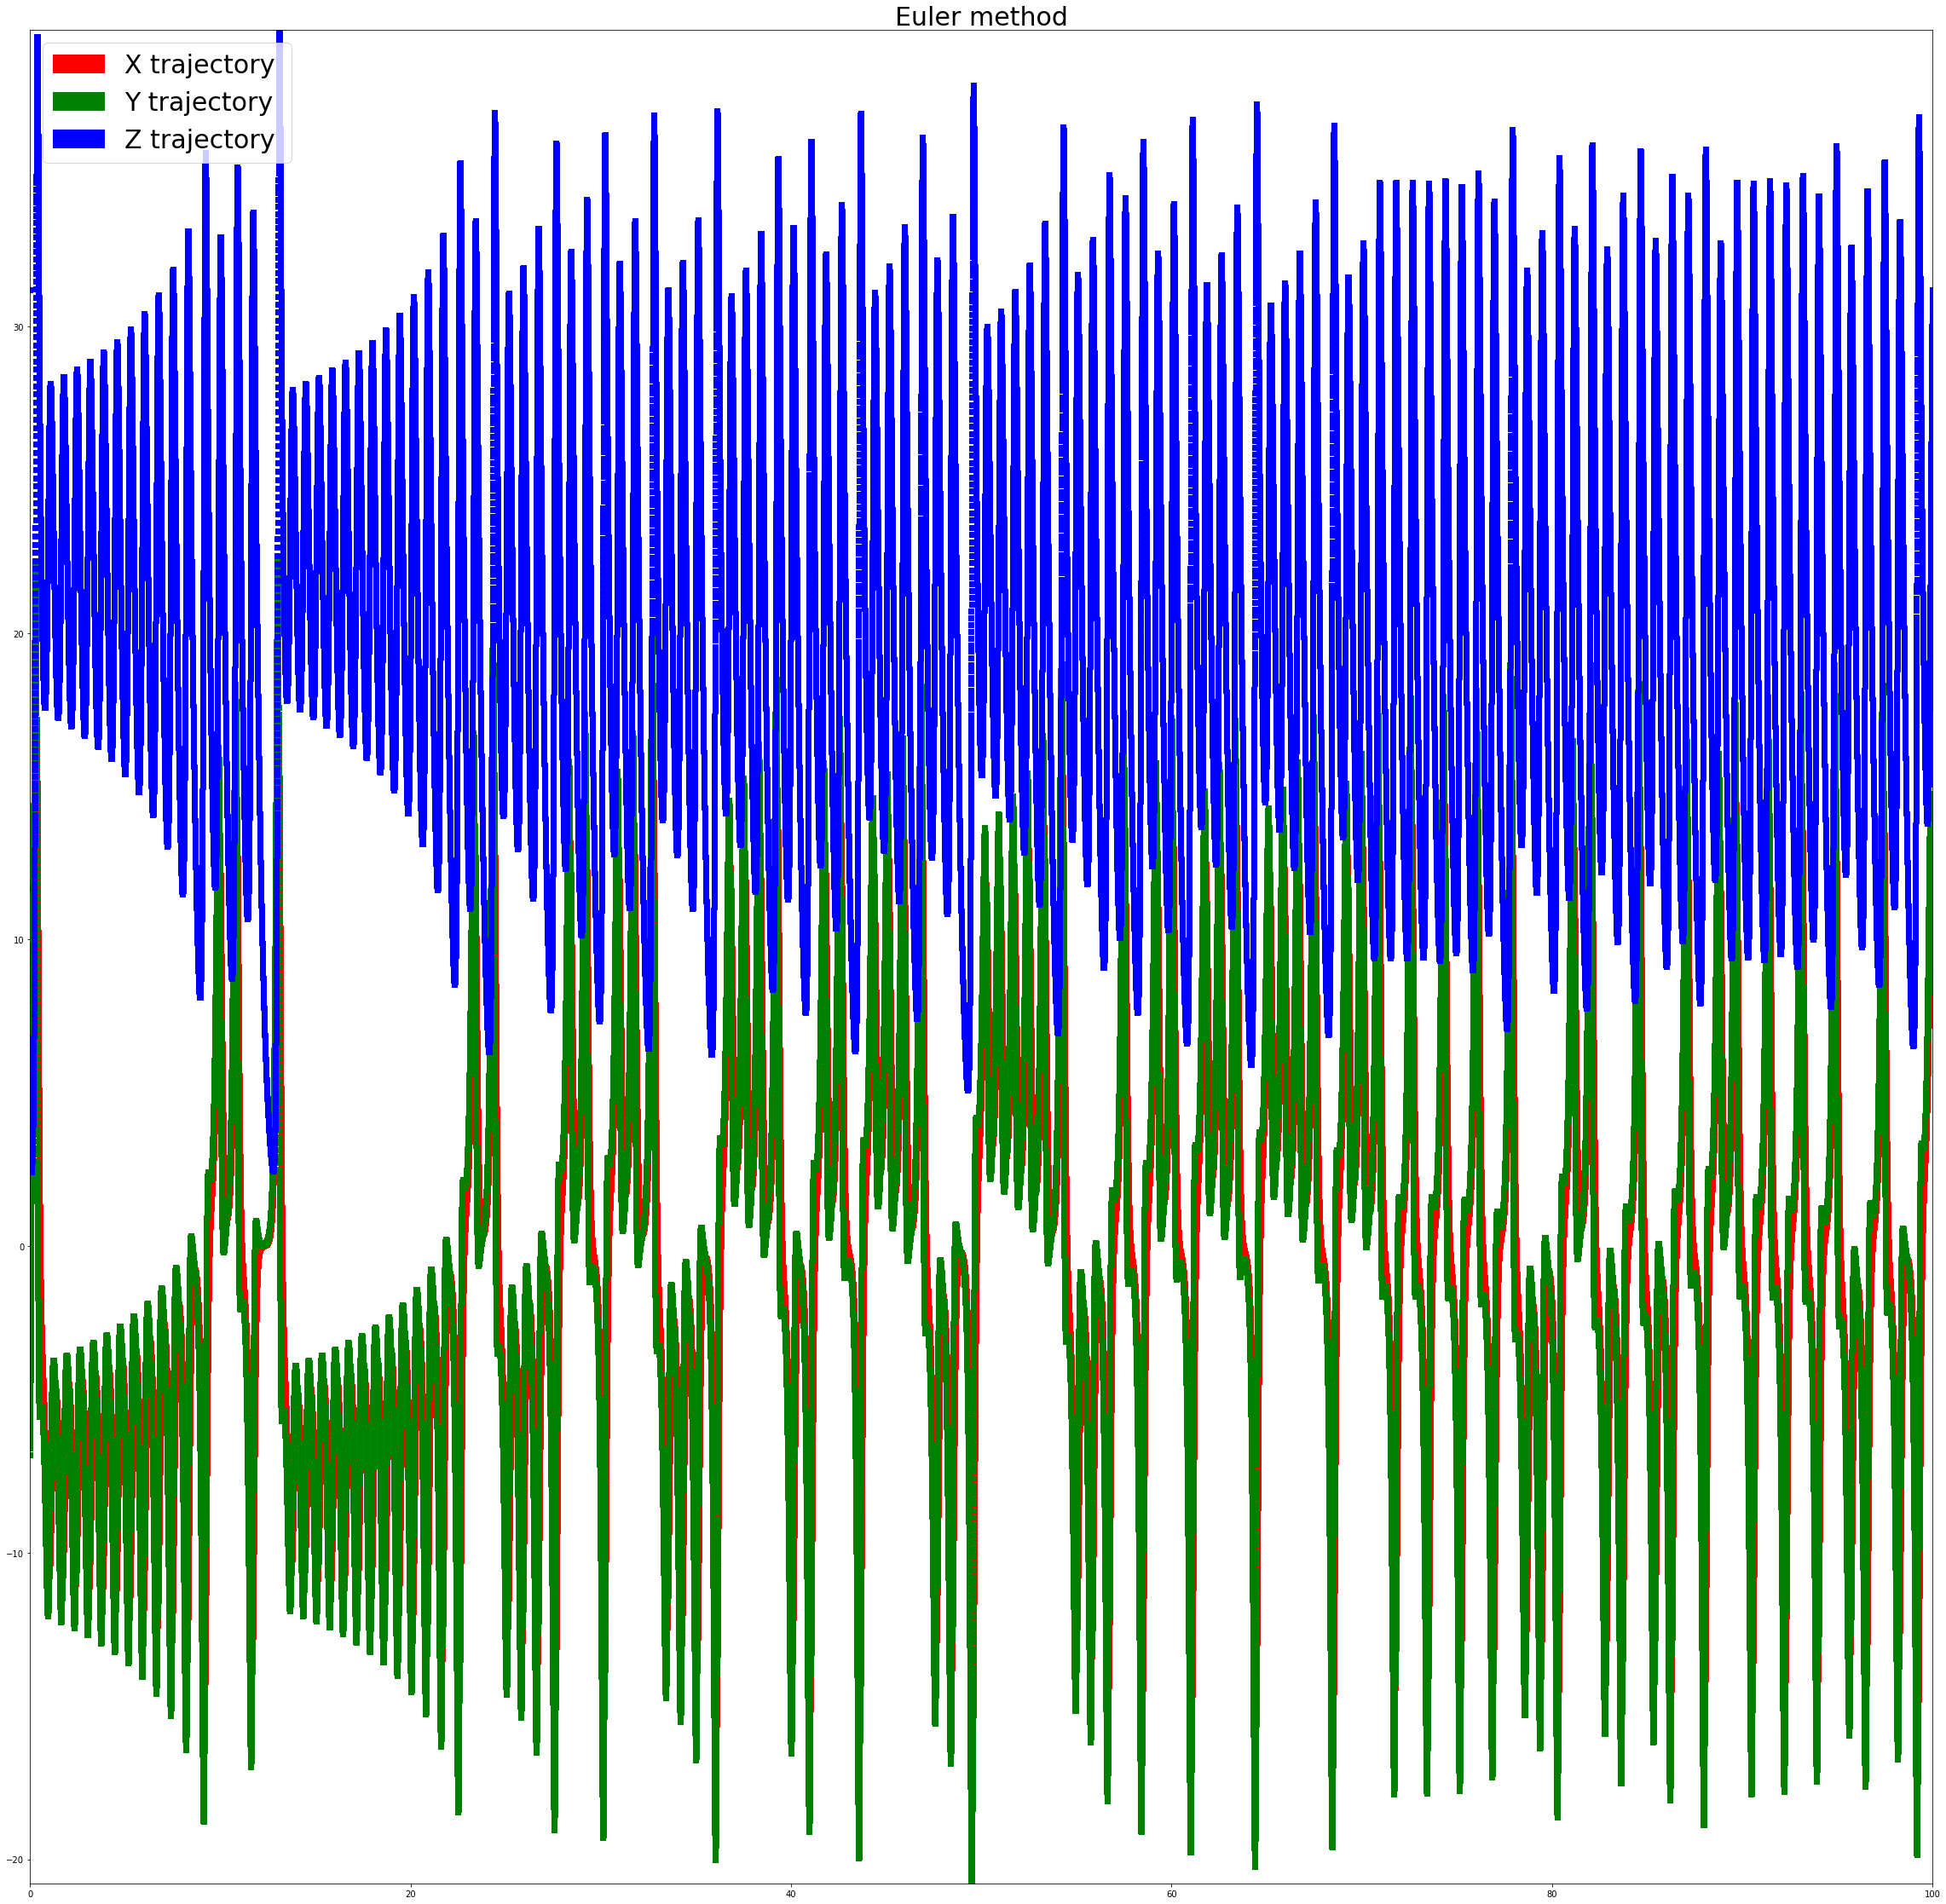

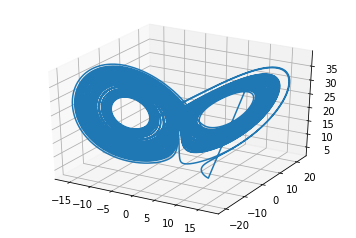

In [16]:
plot_graphs(method_name = "Euler method", 
            method = euler_methodthod, 
            start_x = [10.0, -7.0, 4.0],
            r = 24)

In [51]:
def runge_kutta_method(start_x, r, fun=None, t_a=0, t_b=100, dt=0.001):
    if fun is None:
        fun = lambda vec: lorenz_fun(r, vec)
    cur_t = t_a
    cur_x = np.copy(start_x)
    ts = [cur_t]
    way = [cur_x]
    while cur_t <= t_b:
        k1 = fun(cur_x)
        k2 = fun(cur_x+dt*0.5*k1)
        k3 = fun(cur_x+dt*0.5*k2)
        k4 = fun(cur_x+dt*k3)
        cur_x = cur_x+dt/6*(k1+2*k2+2*k3+k4)
        cur_t += dt
        way.append(np.copy(cur_x))
        ts.append(cur_t)
    return (np.array(ts), np.array(way))

[ -7.48367801  -7.48231464  21.00237526]


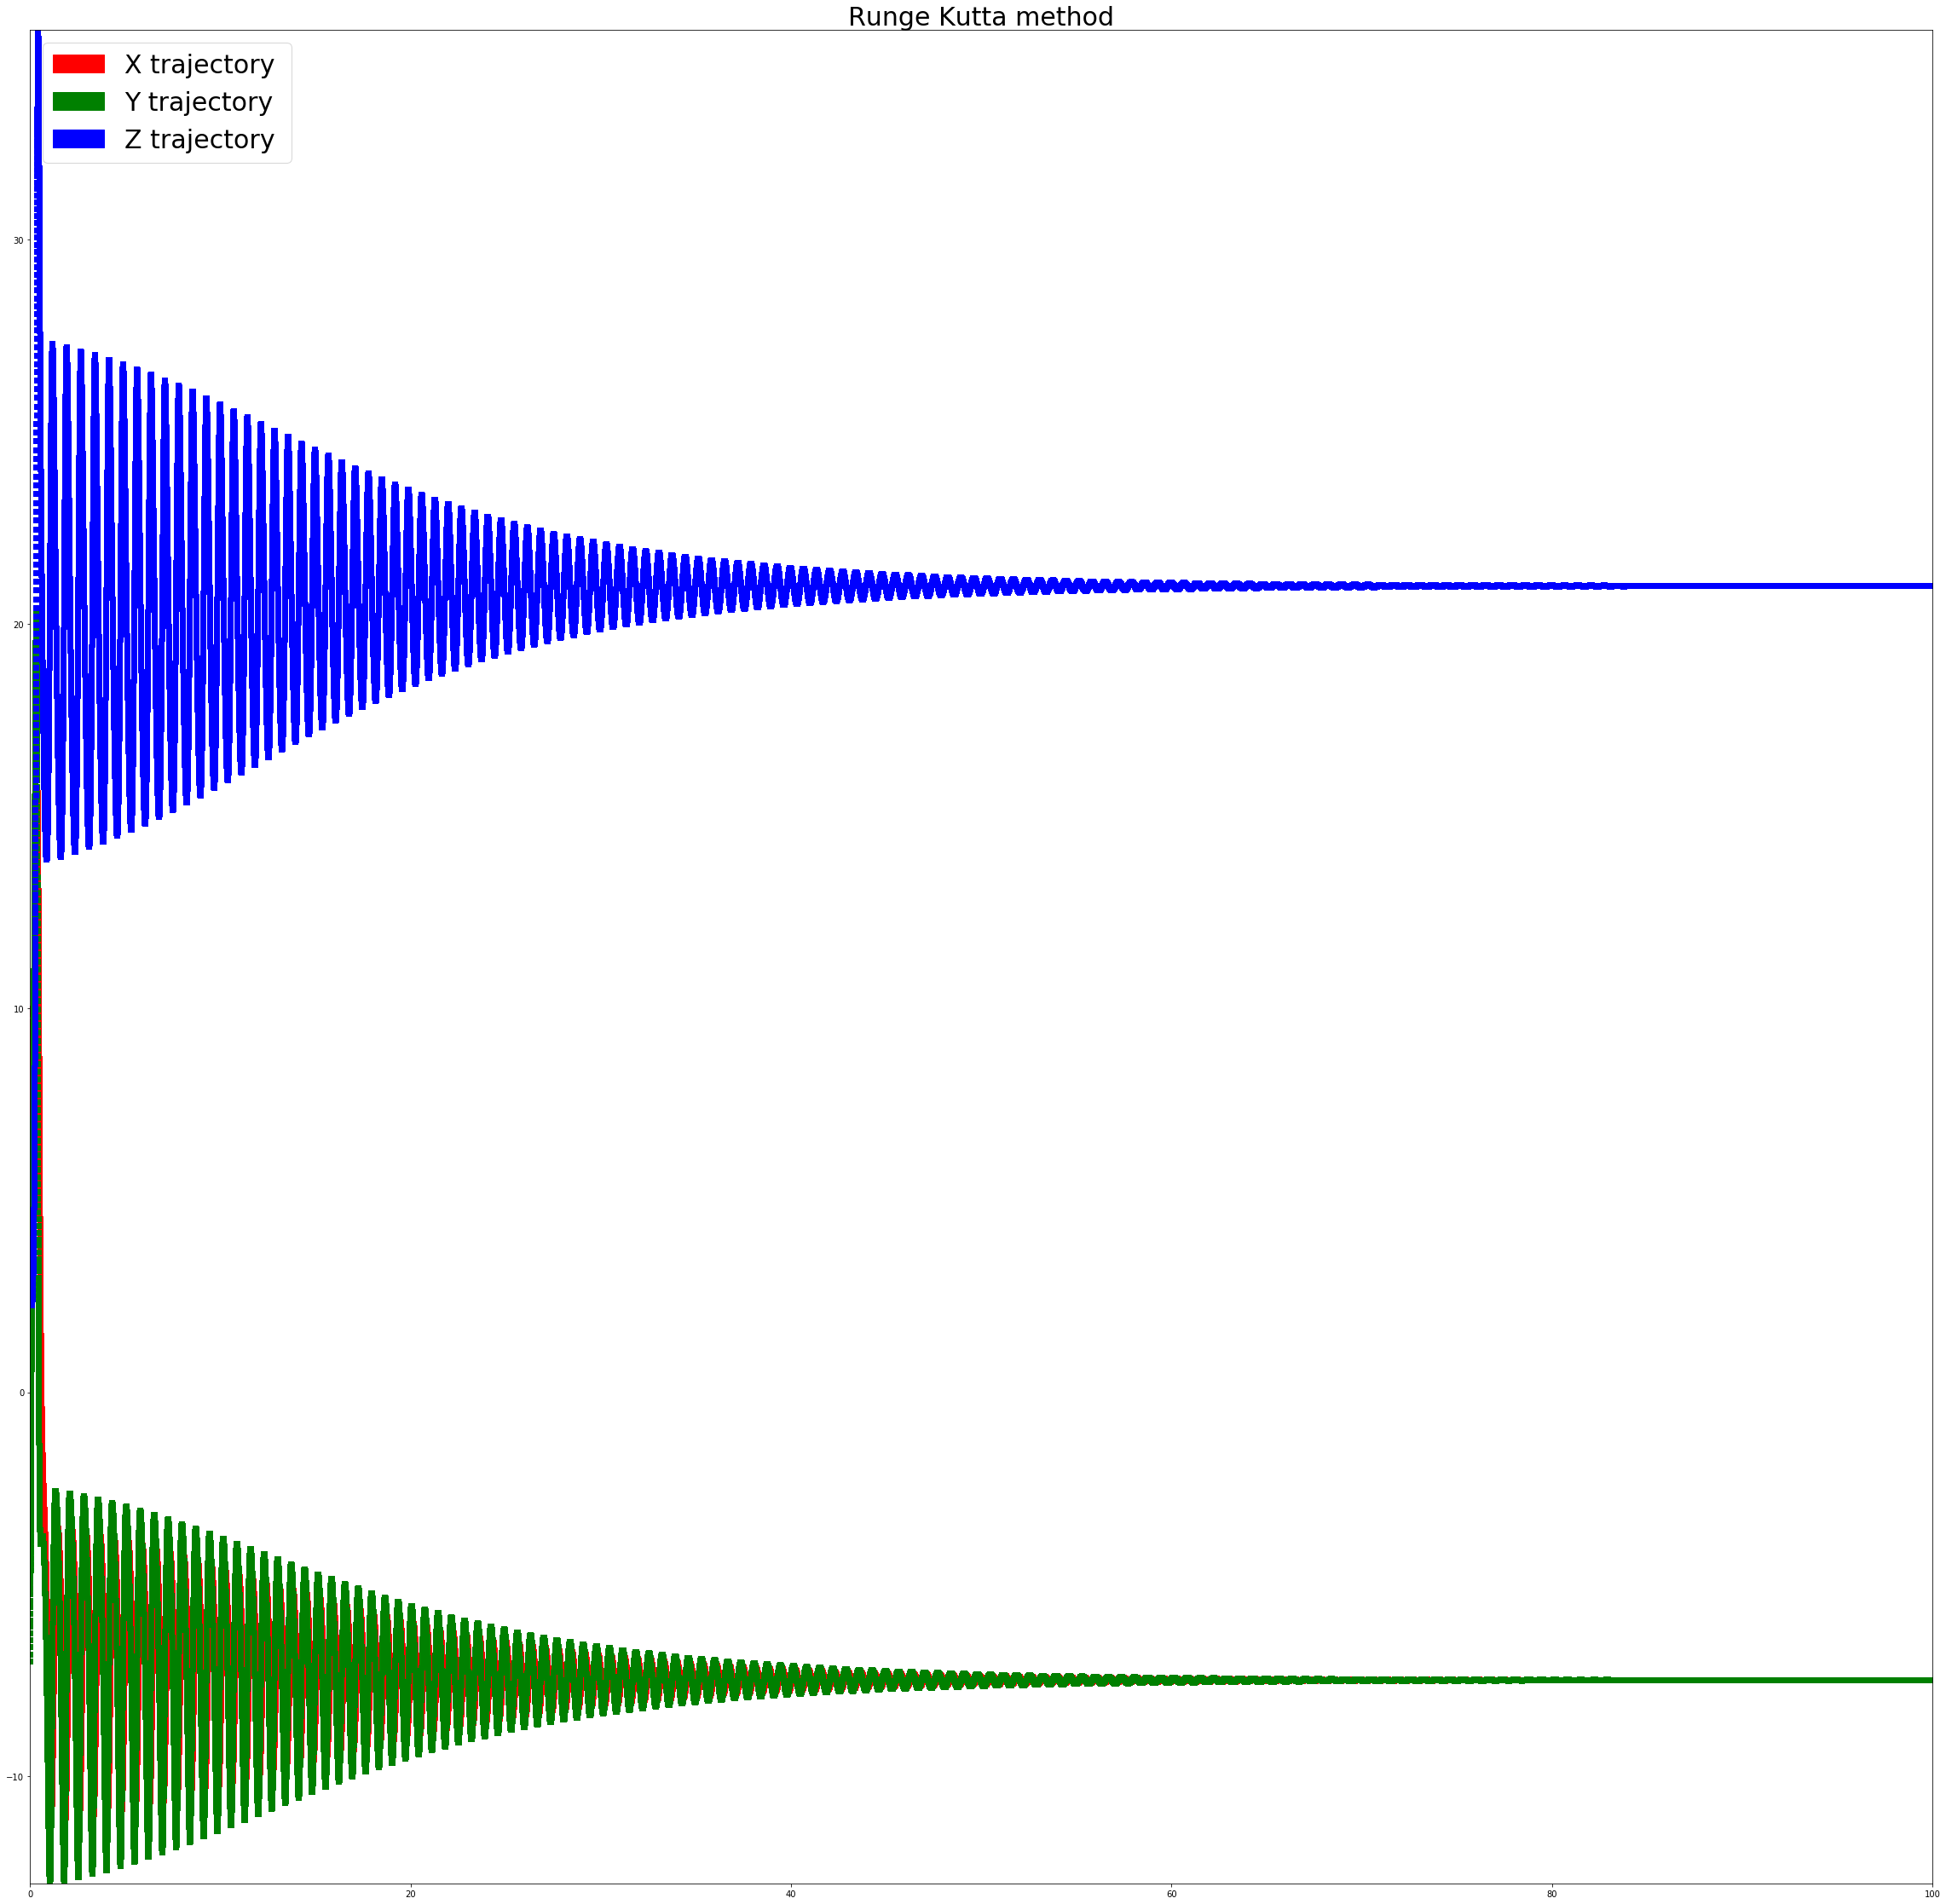

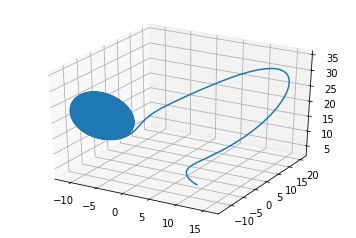

In [52]:
plot_graphs(method_name = "Runge Kutta method", 
            method = runge_kutta_method, 
            start_x = [10.0, -7.0, 4.0],
            r = 22)

In [54]:
EPS = 1e-9

def solve_cubic_equation(u, y0): # solves y=u(y) using Newton
    h = np.polysub(u, np.array([1, 0]))
    dh = np.polyder(h)
    
    cur_y = y0
    next_y = cur_y - np.polyval(h, cur_y) / np.polyval(dh, cur_y)
    while (np.abs(np.polyval(h, cur_y)) > EPS):
        cur_y = np.copy(next_y)
        next_y = cur_y - np.polyval(h, cur_y) / np.polyval(dh, cur_y)
    return cur_y

def solve_system_equality(cur_x, dt, r):
    x0, y0, z0 = cur_x
    ax = np.array([dt*sigma, x0]) / (1+dt*sigma)
     
    az = np.polyadd(np.polymul(ax, np.array([1, 0]))*dt, 
                    np.array([z0])) / (1+dt*b)    
    
    # y=y0-dt*ax*az+dt*r*ax
    fixy = np.array([0,y0])
    fixy = np.polysub(fixy, dt*np.polymul(ax,az))
    fixy = np.polyadd(fixy, dt*r*ax)
    fixy = np.polysub(fixy, np.array([dt, 0]))
    
    ny = solve_cubic_equation(fixy, y0)
    nx = np.polyval(ax, ny)
    nz = np.polyval(az, ny)
    result = np.array([nx, ny, nz])
    return result

def implicit_euler_method(start_x, r, fun=None, t_a=0, t_b=20, dt=0.001):
    cur_t = t_a
    cur_x = np.copy(start_x)
    ts = [cur_t]
    way = [cur_x]
    while cur_t <= t_b:
        cur_x = solve_system_equality(cur_x, dt, r)
        cur_t += dt
        way.append(np.copy(cur_x))
        ts.append(cur_t)
    return (np.array(ts), np.array(way))

[ -7.65901887  -7.6592137   21.99927328]


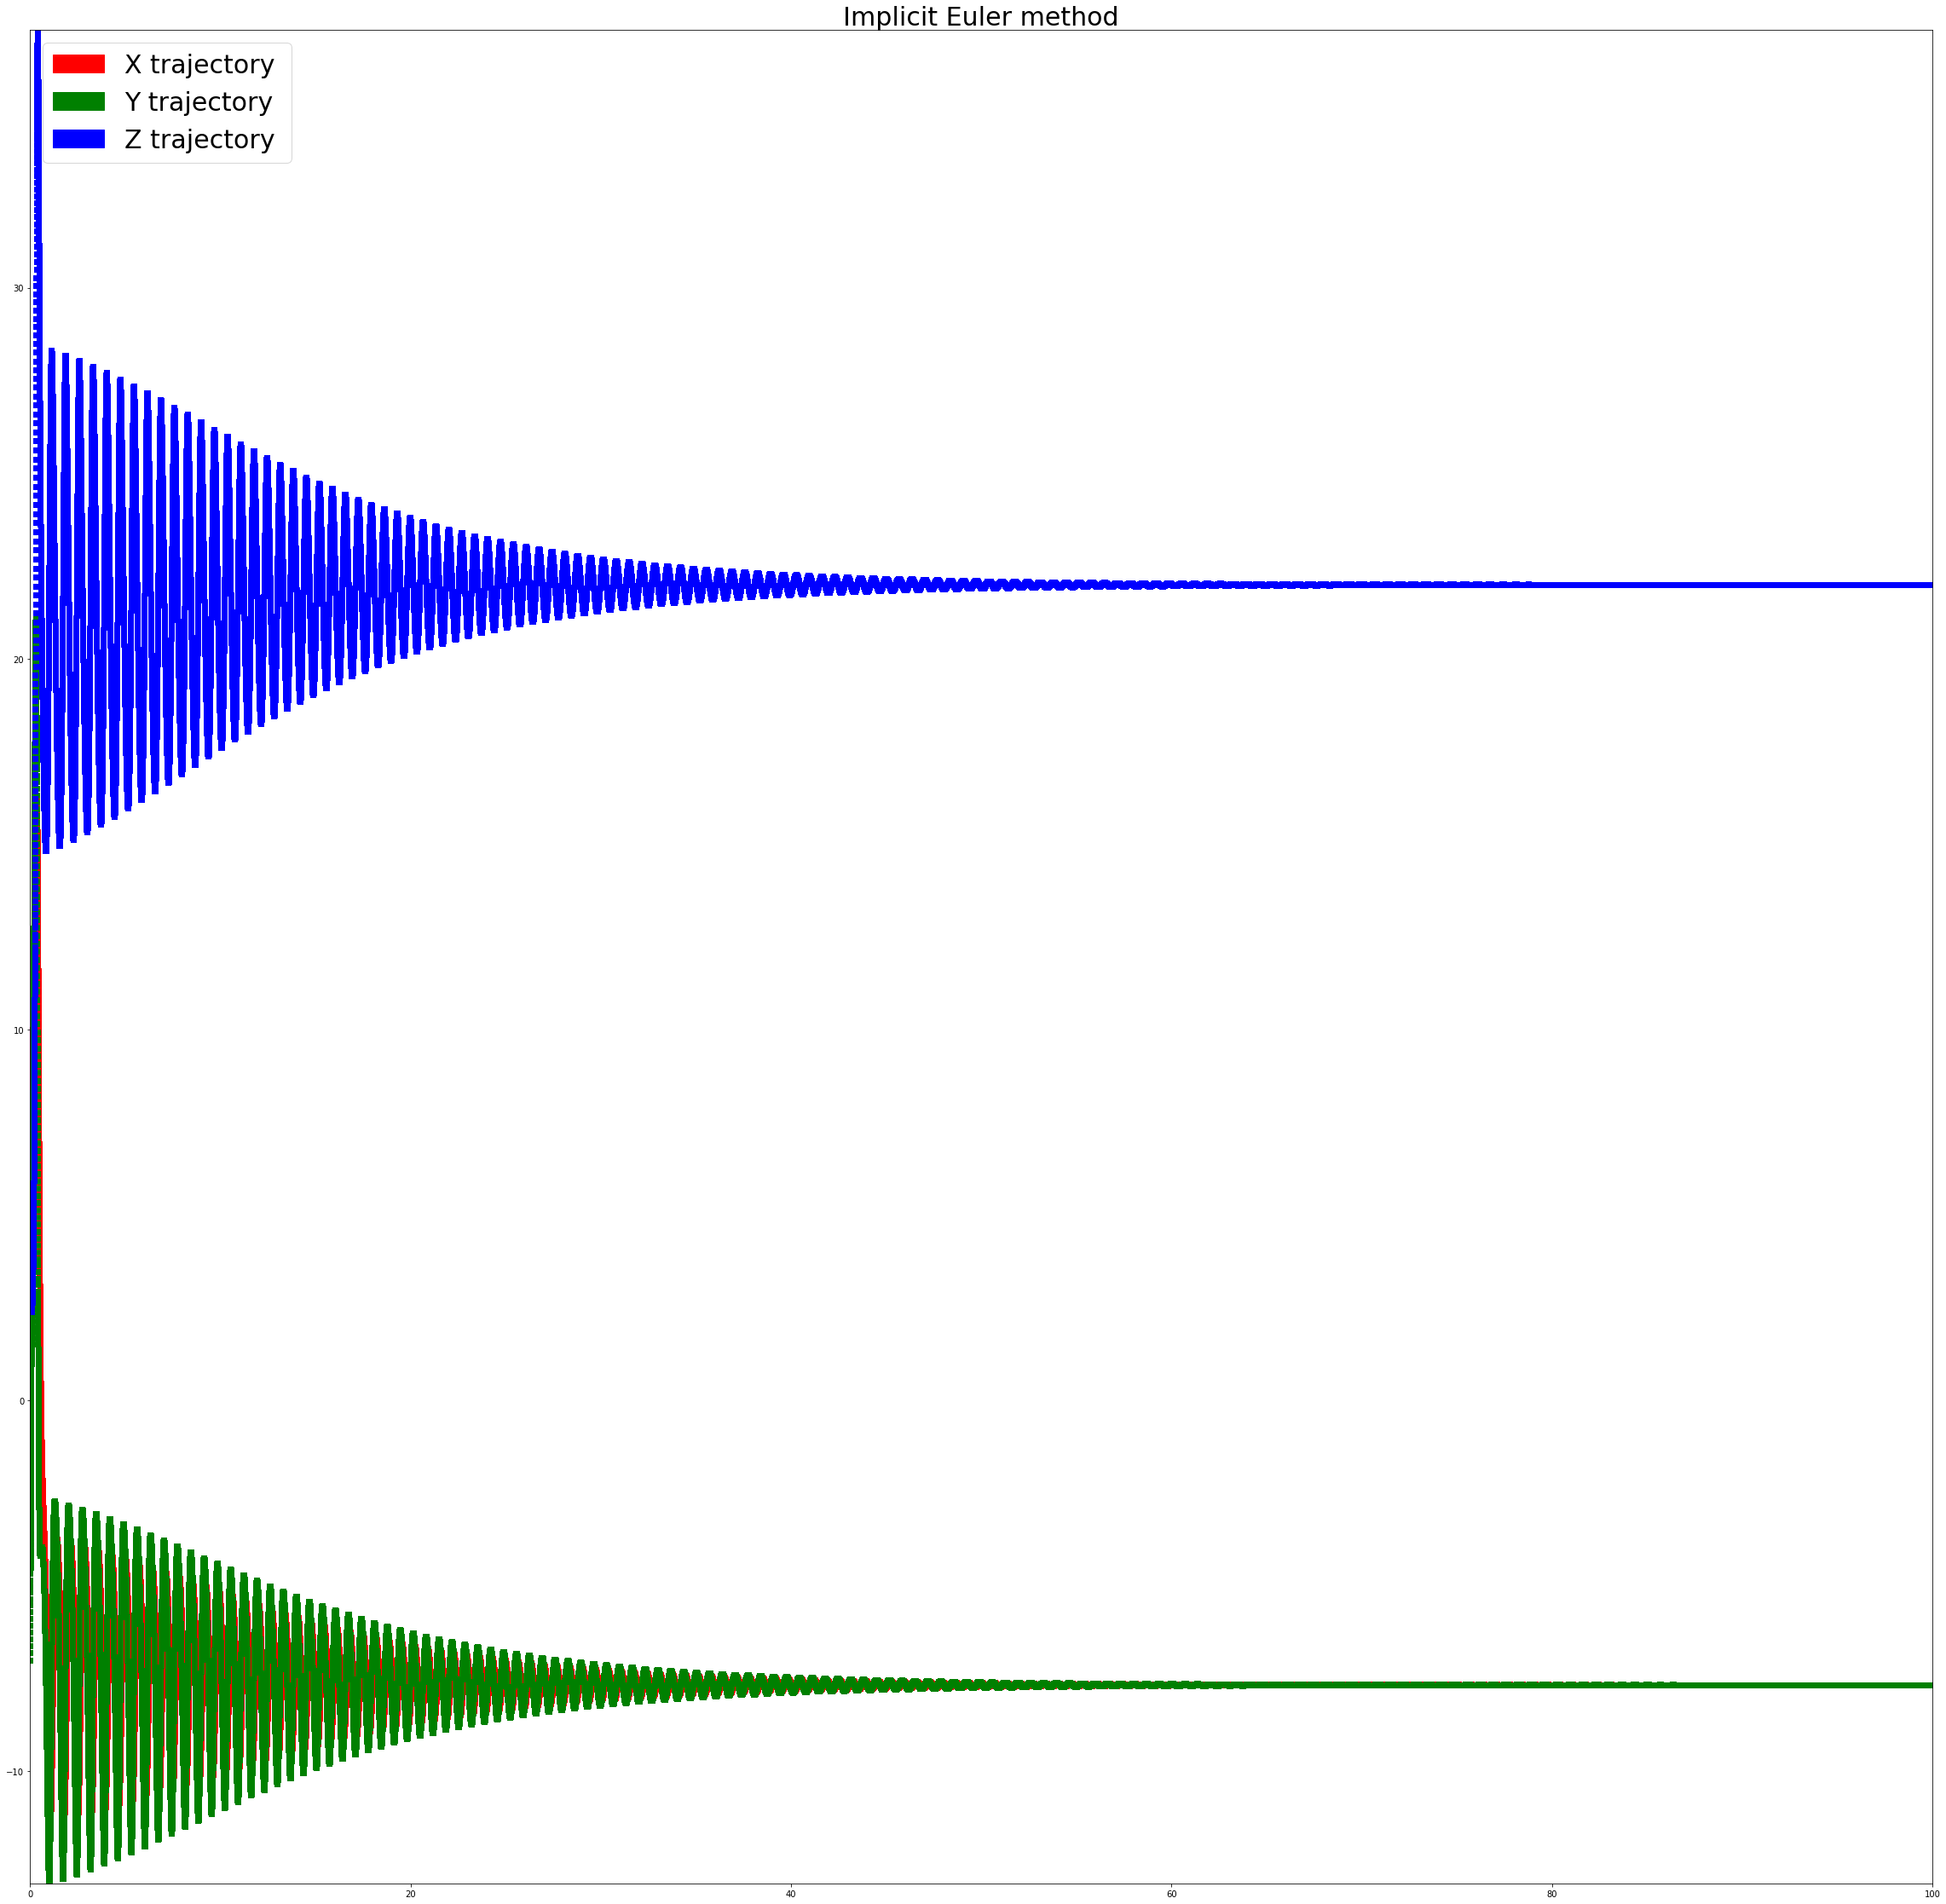

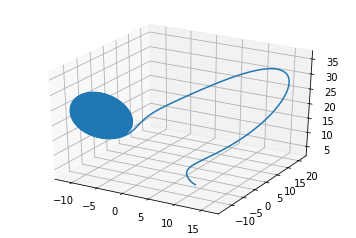

In [56]:
plot_graphs(method_name = "Implicit Euler method", 
            method = implicit_euler_method, 
            start_x = [10.0, -7.0, 4.0],
            r = 23)

In [64]:
def adams_method(start_x, r, fun=None, t_a=0, t_b=100, dt=0.001):
    if fun is None:
        fun = lambda vec: lorenz_fun(r, vec)
    cur_t = t_a
    cur_x = np.copy(start_x)
    ts = [cur_t]
    way = [cur_x]
    while cur_t <= t_b:
        if len(way) <= 4:
            cur_x += fun(cur_x) * dt
            cur_t += dt
        else:
            p0, p1, p2, p3 = map(fun, way[-4:])
            pred = cur_x + (dt/24) * (55*p0-59*p1+37*p2-9*p3)
            p_1 = fun(pred)
            corr = cur_x + (dt/24) * (9*p_1+19*p0-5*p1+p2)
            cur_x = np.copy(corr)
            cur_t += dt
        way.append(np.copy(cur_x))
        ts.append(cur_t)
            
    return (np.array(ts), np.array(way))

[  7.1230812    7.12489748  19.00263345]


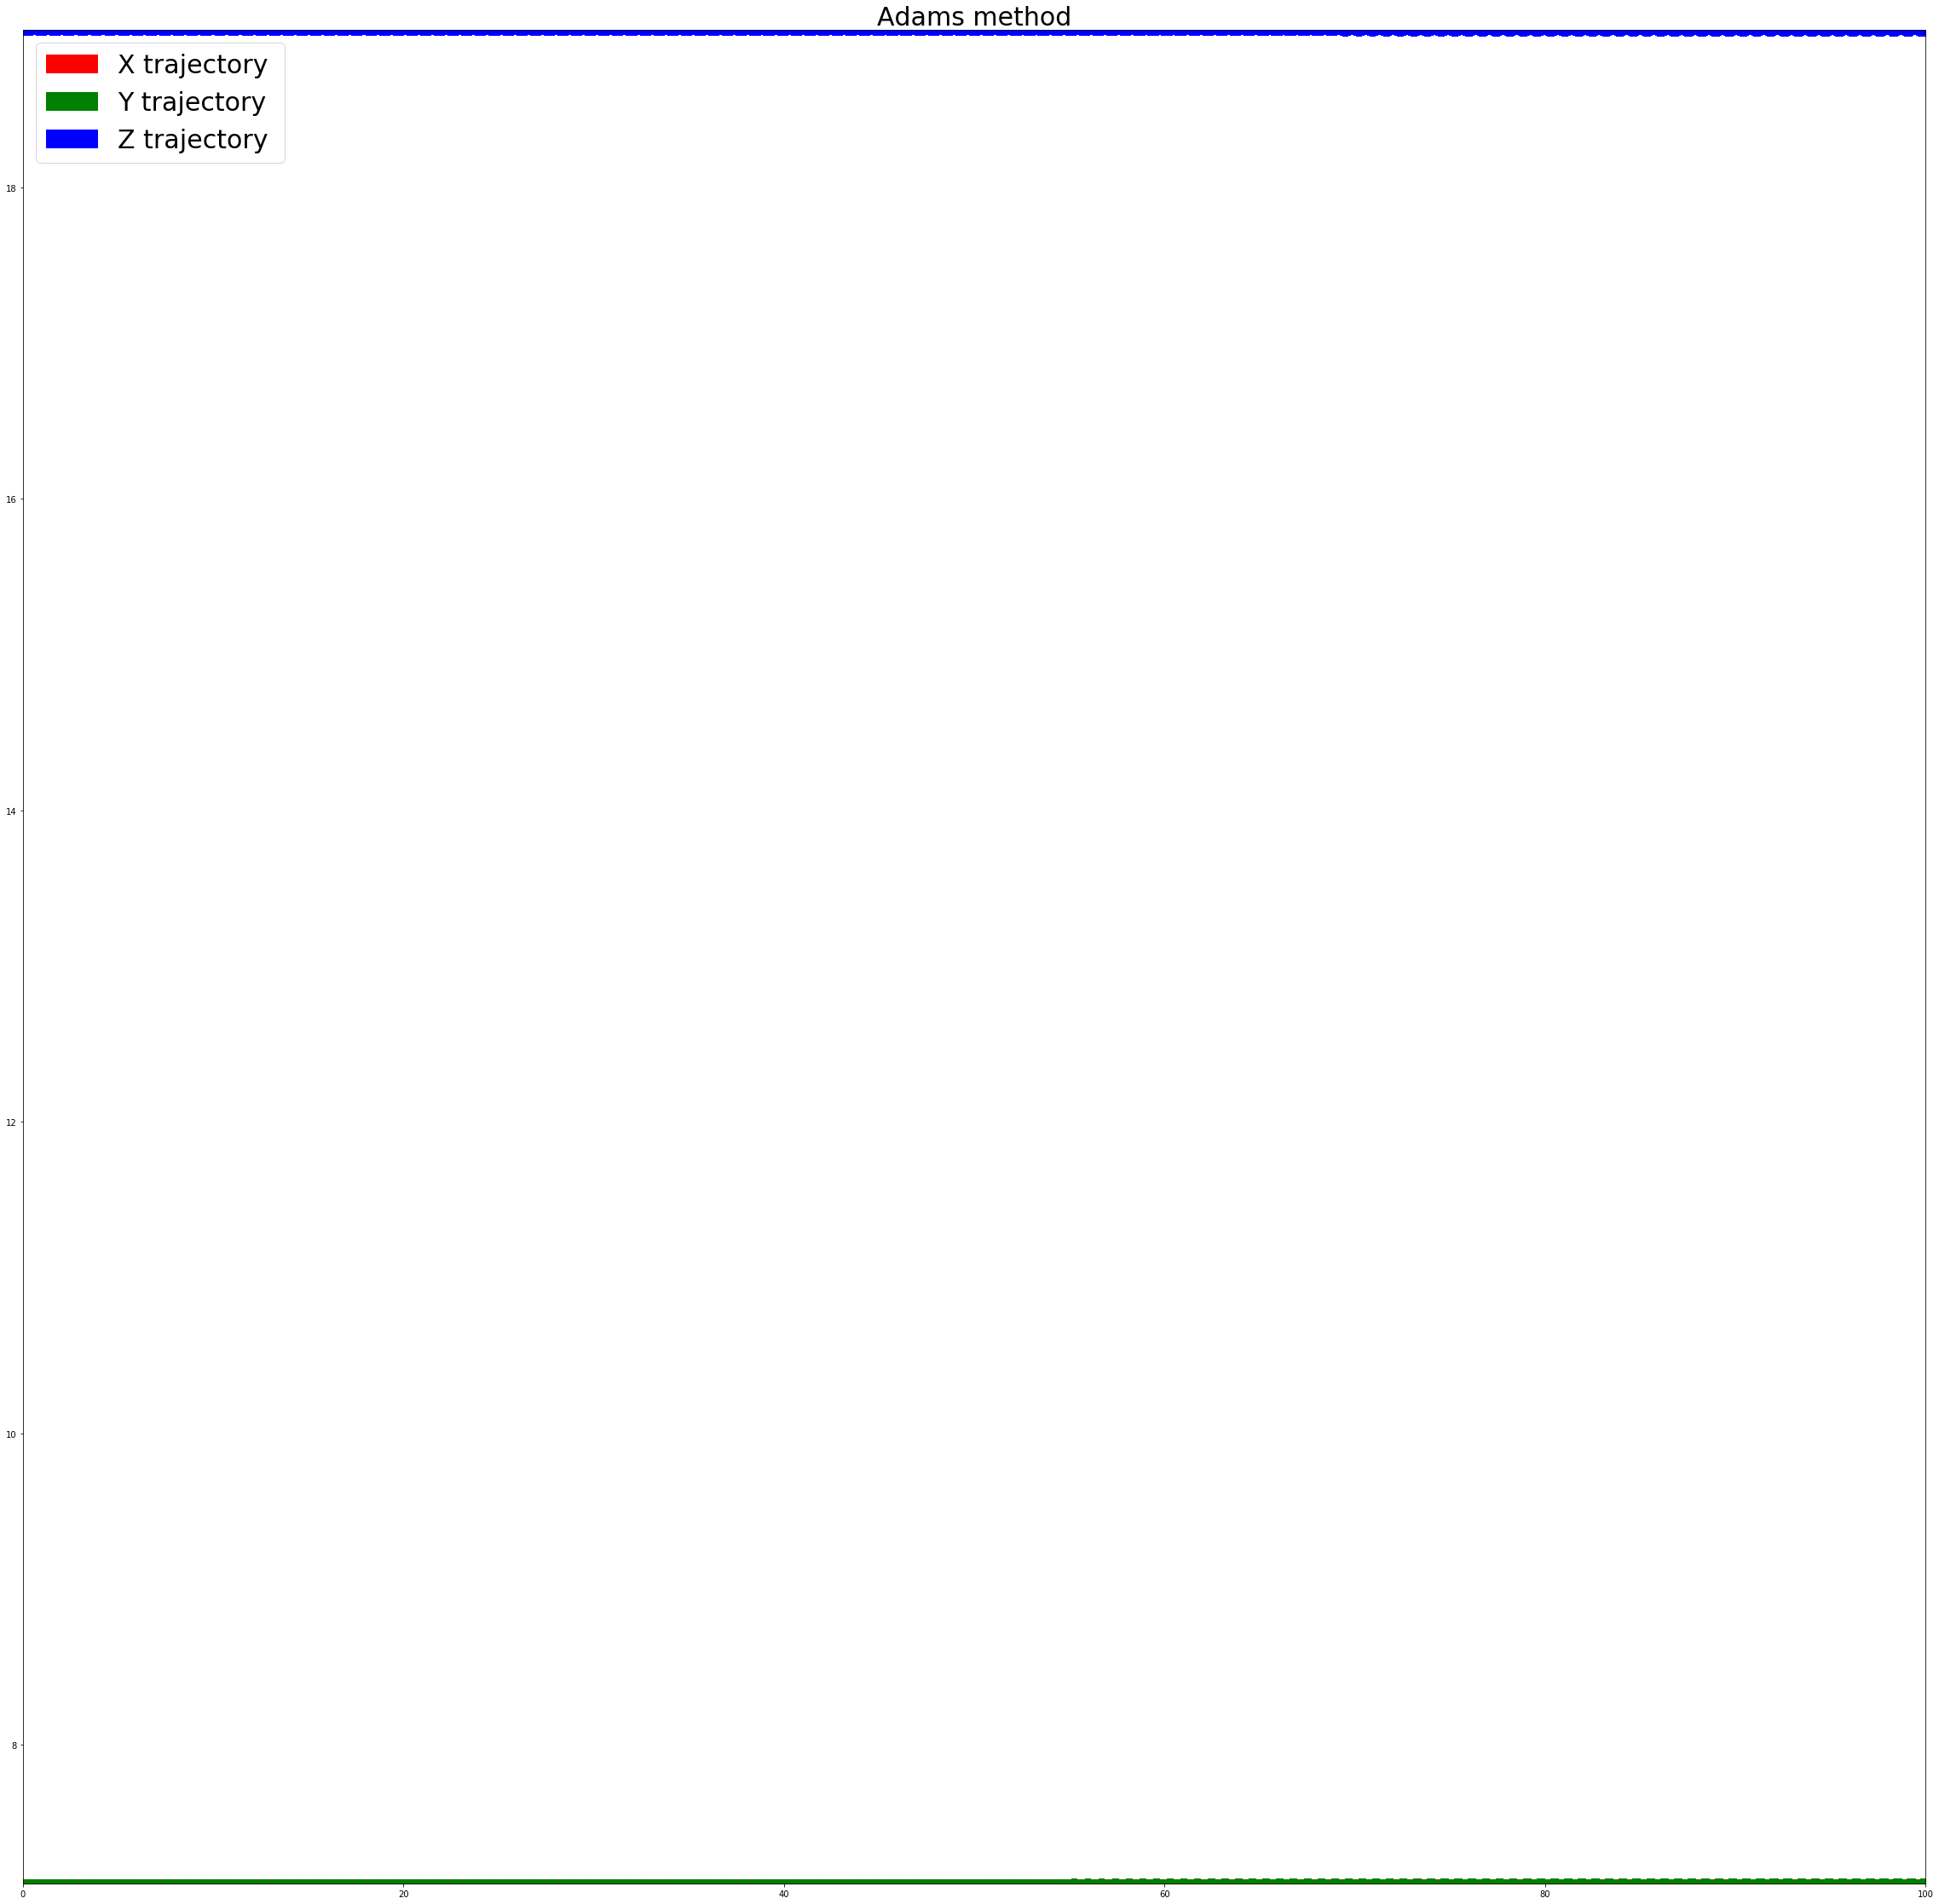

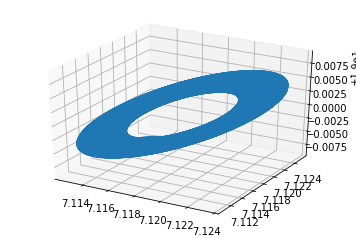

In [76]:
# plot_graphs(method_name = "Adams method", 
#             method = adams_method, 
#             start_x = [0.0, 0.0, 0.0],
#             r = 22)
tr=20
plot_graphs(method_name = "Adams method",
            method = adams_method,
            start_x = [np.sqrt(b*(tr-1))+0.003, -0.005+np.sqrt(b*(tr-1)), tr-1],
            r = tr)


In [36]:
def final_points(method, start_x):
    global r
    for r_id in range(100):
        r = 30.0 * r_id / 100
        x, y, z = converge_to(method, start_x)
        print("%.2f converjed to (%.3f %3.f %3.f)" % (r, x, y, z))

In [ ]:
np.savetxt("data.csv", points, delimiter=' ')